# Analyses - Figure 4, S8 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
import scipy as sci

import gseapy as gp
from xlrd import XLRDError
import xlsxwriter

/Users/sophie/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.0.4+92.g9a754bb.dirty anndata==0.5.10 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.settings.writedir='./data/'
sc.settings.figdir='./figures/'

In [4]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

In [5]:
adata_all = sc.read('./data/adata_processed.h5')

In [6]:
adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

## Cell cycle scoring

cell cycle scoring as described in scanpy API, 2017: https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/cell_cycle.ipynb

**Note**: there may be small variation in cell cycle scores and phase annotation of cells when the cell cycle scores are recomputed as a random set of background genes is used for testing. For exact reproducibility use the pre-computed scores in the provided anndata.

In [7]:
cell_cycle_genes = [x.strip() for x in open('./cell_cycle_genes.txt')]

In [8]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_all.var_names]

In [9]:
sc.tl.score_genes_cell_cycle(adata_all, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
['Tmem125', 'Dolpp1', 'A130010J15Rik', 'Trappc13', 'Tmem53', 'Tia1', 'Pak4', 'Gpn1', 'Rab5b', 'Ahcy', 'Fbxl4', 'Itgb1', 'Manea', 'Med4', 'Bahcc1', 'Pop7', 'Tor2a', '2610035D17Rik', 'Taf7', 'Acsf2', 'Atm', 'Lztfl1', 'Lcor', 'Psme3', 'Ticrr', 'Upp1', 'Slc9a6', 'Rab11fip2', 'Rasal2', 'Pan3', 'Brwd1', 'Dopey2', 'Sssca1', 'Cwc22', 'Tfrc', 'Amacr', 'Phc2', 'Lrrc41', 'Aph1a', 'Arglu1', 'Rnf11', 'Baiap2l2', 'Ccdc47', 'Naprt', 'Adsl', 'Sidt2', 'Dhx16', 'Ccdc191', 'Npc1l1', 'Reg3g', 'Ppie', 'Fmo5', 'Sft2d2', 'Gtf2h1', 'Fbxo8', 'Arhgap31', 'Pdgfa', 'Ogfod2', 'Dnajc30', 'Coq3', 'Ing2', 'G6pc3', 'Cnot1', 'Pole3', 'Exog', 'Kif11', 'Tmem86a', 'Dgkq', 'Sdad1', 'Sugp2', 'Hmgxb4', 'Entpd7', 'Slc44a1', 'Taf8', 'Cbx4', 'Shroom3', 'Sept2', 'Uaca', 'Srsf10', 'Gtf2b', 'Trmt10c', 'Coa5', 'Maoa', 'Tiam1', 'Pitrm1', 'Echdc2', 'Nme4', 'Mplkip', 'Fip1l1', 'Hiat1', 'Htatsf1', 'Unk', 'Psmd1', 'Ms4a10', 'Klhdc10', 'Malrd1', 'Elovl1', 'Mcts1', 'Thra', 'Eif4a3', '

In [10]:
adata_all.obs['proliferation'] = ['Non-Cycling' if phase=='G1' else 'Cycling' for phase in adata_all.obs['phase']]
adata_all.obs['proliferation'] = pd.Categorical(adata_all.obs['proliferation'])

In [11]:
adata_all_hvg.obs['phase'] = adata_all.obs['phase']
adata_all_hvg.obs['proliferation'] = adata_all.obs['proliferation']

plots

... storing 'phase' as categorical


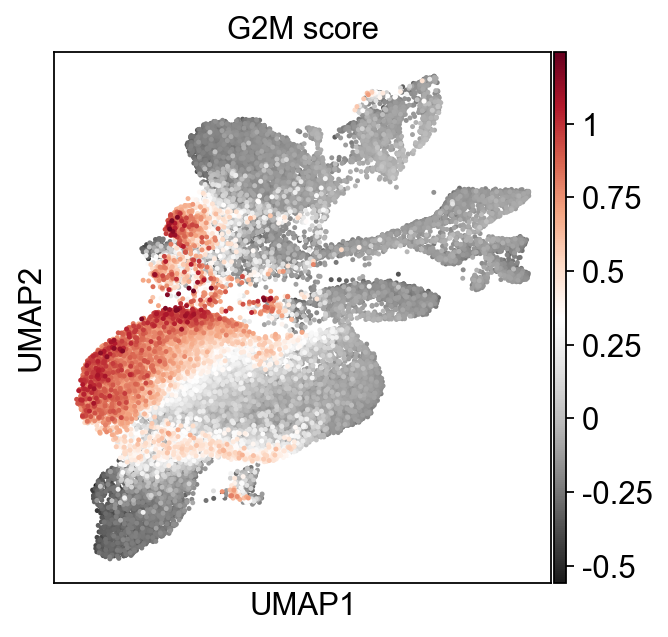

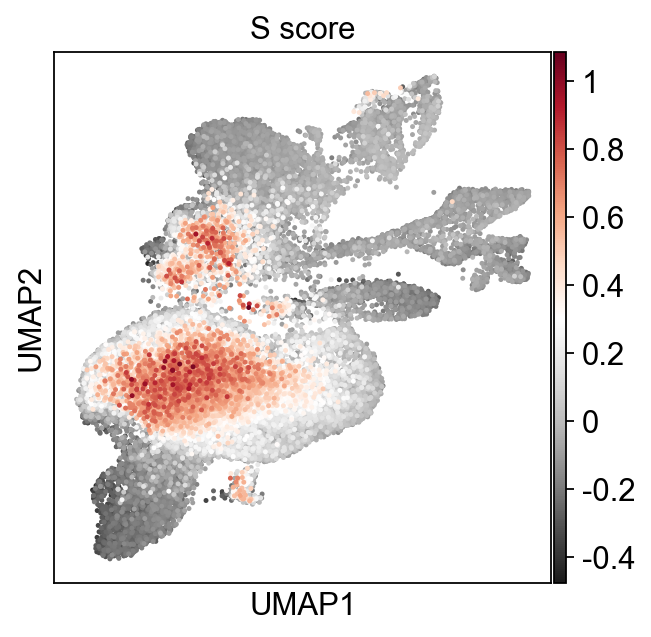

In [12]:
sc.pl.umap(adata_all, color=['G2M_score'], color_map='RdGy_r', size=20)
sc.pl.umap(adata_all, color=['S_score'], color_map='RdGy_r', size=20)

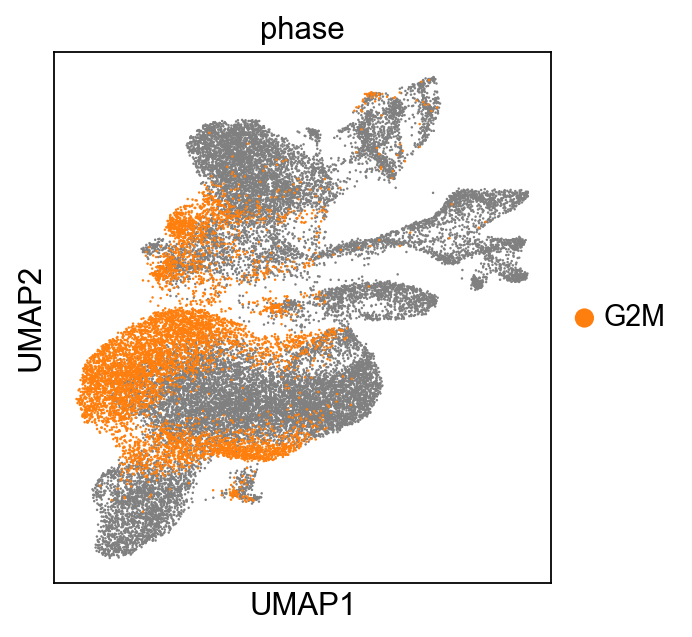

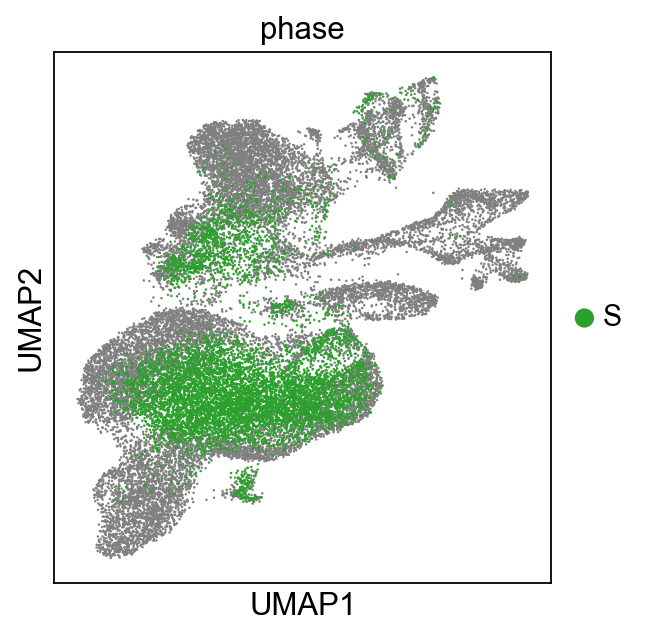

In [15]:
sc.pl.umap(adata_all, color=['phase'], groups=['G2M'], palette=['red'], size=5)
sc.pl.umap(adata_all, color=['phase'], groups=['S'], palette=['red'], size=5)

## Cell densities

**note**: in new versions of scanpy this is wrapped in: sc.tl.embedding_density() and sc.pl.embedding_density()

In [16]:
def cal_density_obs(adata, obsm, obsname):

    from scipy.stats import gaussian_kde

    x = adata.obsm[obsm][:, 0]
    y = adata.obsm[obsm][:, 1]

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    adata.obs[obsname+'_density'] = z

    return(adata)

In [17]:
def plot_density_obs(adata, adata_full, obsm, obsname, cmap='Greys', greysize=5, colorsize=10, colbar=False, vmax=0, vmin=0, savefile=None, dpisave=300):

    z = adata.obs[obsname+'_density']
    x = adata.obsm[obsm][:, 0]
    y = adata.obsm[obsm][:, 1]
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = pl.subplots()
    ax.scatter(adata_full.obsm[obsm][:, 0], adata_full.obsm[obsm][:, 1], c='lightgrey', edgecolor='', s=greysize, rasterized=True)
        
    if vmax==0:
        vmax=max(z)
    
    ax.scatter(x, y, c=z, s=colorsize, edgecolor='', cmap=cmap, vmax=vmax, vmin=vmin, rasterized=True)
    if colbar:
        fig.colorbar(i,ax=ax)
    pl.grid(b=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    
    
    pl.xlabel('dim 1')
    pl.ylabel('dim 2')
    pl.xticks([])
    pl.yticks([])
    
    if savefile is not None:
        pl.savefig(savefile, dpi=dpisave, format='pdf')
    pl.show()
    return()

### cell cycle split by condition

Cycling


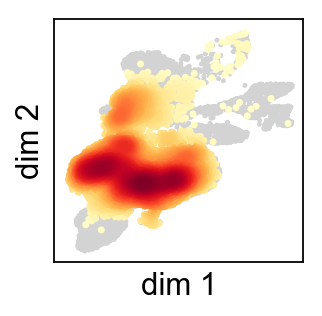

Non-Cycling


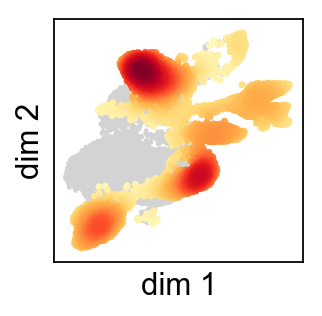

In [18]:
adata_cd = adata_all[adata_all.obs['diet'].isin(['CD'])].copy()
for cat in adata_cd.obs['proliferation'].cat.categories:
    rcParams['figure.figsize'] = (2, 2)
    adata_sub = adata_cd[adata_cd.obs['proliferation'].isin([cat]), :].copy()
    adata_sub = cal_density_obs(adata_sub,'X_umap', cat)
    print(cat)
    plot_density_obs(adata_sub, adata_cd, 'X_umap', cat, cmap='YlOrRd')

Cycling


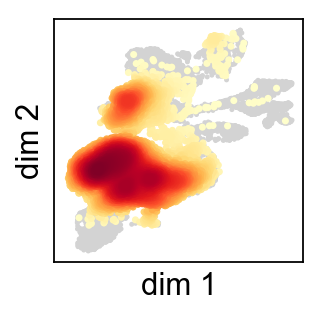

Non-Cycling


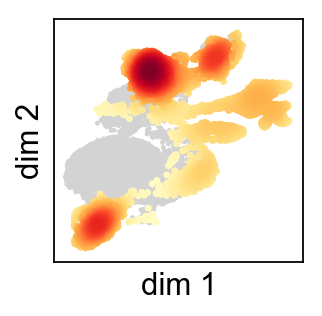

In [19]:
adata_hfd = adata_all[adata_all.obs['diet'].isin(['HFD'])].copy()
for cat in adata_hfd.obs['proliferation'].cat.categories:
    rcParams['figure.figsize'] = (2, 2)
    adata_sub = adata_hfd[adata_hfd.obs['proliferation'].isin([cat]), :].copy()
    adata_sub = cal_density_obs(adata_sub,'X_umap', cat)
    print(cat)
    plot_density_obs(adata_sub, adata_hfd, 'X_umap', cat, cmap='YlOrRd')

## Cell type frequencies

**Note**: there may be small variation in cell cycle scores and phase annotation of cells when the cell cycle scores are recomputed as a random set of background genes is used for testing. For exact reproducibility use the pre-computed scores in the provided anndata.

In [19]:
# adata_all = sc.read('./data/adata_processed.h5')
# adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

In [20]:
# adata_all.obs['proliferation'] = ['Non-Cycling' if phase=='G1' else 'Cycling' for phase in adata_all.obs['phase']]
# adata_all.obs['proliferation'] = pd.Categorical(adata_all.obs['proliferation'])

### Overall frequencies

total number of cycling cells

In [21]:
sub_cells = adata_all.obs['diet'].isin(['CD'])

data = adata_all.obs[['proliferation','sample']][sub_cells]
tot = data.groupby(['proliferation','sample']).size().unstack().fillna(0)

y_freq = tot.transform(lambda x: x/sum(x))
y_mean = y_freq.apply(np.mean, axis=1)
y_se = y_freq.apply(np.std, axis=1)/np.sqrt(len(np.unique(adata_all.obs['sample'])))

print(y_mean)

proliferation
Cycling        0.528531
Non-Cycling    0.471469
dtype: float64


In [22]:
sub_cells = adata_all.obs['diet'].isin(['HFD'])

data = adata_all.obs[['proliferation','sample']][sub_cells]
tot = data.groupby(['proliferation','sample']).size().unstack().fillna(0)

y_freq = tot.transform(lambda x: x/sum(x))
y_mean = y_freq.apply(np.mean, axis=1)
y_se = y_freq.apply(np.std, axis=1)/np.sqrt(len(np.unique(adata_all.obs['sample'])))

print(y_mean)

proliferation
Cycling        0.550003
Non-Cycling    0.449997
dtype: float64


cell frequencies per phase in CD mice

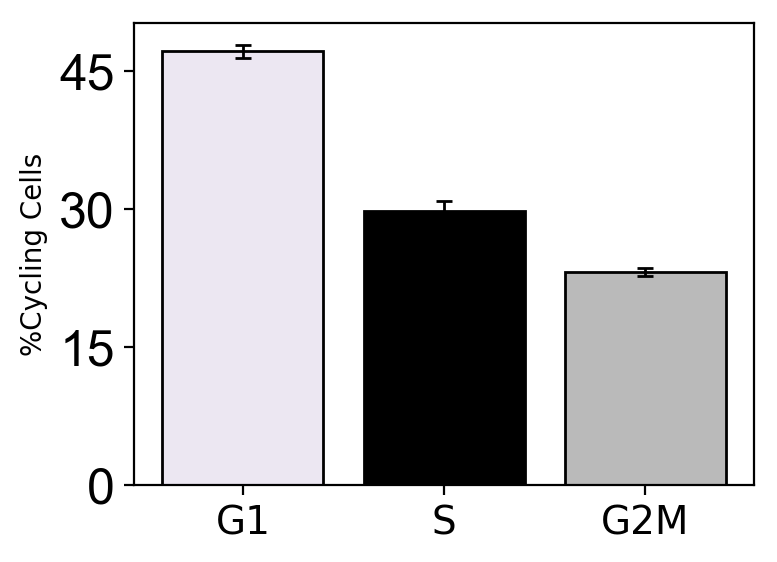

In [26]:
rcParams['figure.figsize'] = (4,3)

sub_cells = adata_all.obs['diet'].isin(['CD'])

data = adata_all.obs[['phase','sample']][sub_cells]
tot = data.groupby(['phase','sample']).size().unstack().fillna(0)

y_freq = tot.transform(lambda x: x/sum(x))
y_freq = y_freq.loc[['G1','S','G2M']]
y_mean = y_freq.apply(np.mean,axis=1)
y_se = y_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all.obs['sample'])))

rects1 = pl.bar([1,1.5,2], y_mean*100, 0.4, color=['#ece7f2','black','#bababa'] ,edgecolor='black',
                yerr=y_se*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))

pl.xticks([1,1.5,2], ['G1','S','G2M'], rotation=0, fontsize=14)
pl.yticks([0,15,30,45], ['0','15','30','45'], rotation=0, fontsize=18, fontname='Arial')
pl.xlabel('')
pl.ylabel('%Cycling Cells')

pl.show()

pl.rcParams.update(pl.rcParamsDefault)


cell frequencies per phase in HFD mice

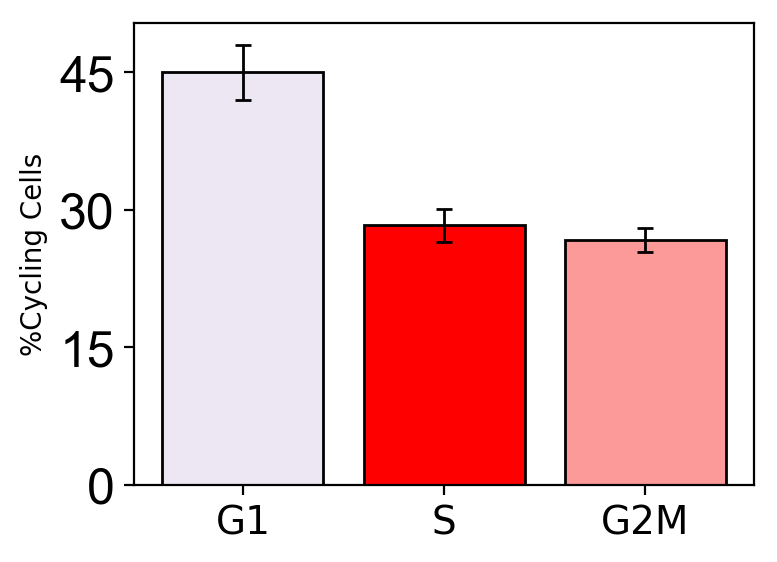

In [27]:
rcParams['figure.figsize'] = (4,3)

sub_cells = adata_all.obs['diet'].isin(['HFD'])

data = adata_all.obs[['phase','sample']][sub_cells]
tot = data.groupby(['phase','sample']).size().unstack().fillna(0)

y2_freq = tot.transform(lambda x: x/sum(x))
y2_freq = y2_freq.loc[['G1','S','G2M']]
y2_mean = y2_freq.apply(np.mean,axis=1)
y2_se = y2_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all.obs['sample'])))

rects1 = pl.bar([1,1.5,2], y2_mean*100, 0.4, color=['#ece7f2','red','#fb9a99'], edgecolor='black',
                yerr=y2_se*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))

pl.xticks([1,1.5,2], ['G1','S','G2M'], rotation=0, fontsize=14)
pl.yticks([0,15,30,45], ['0','15','30','45'], rotation=0, fontname='Arial', fontsize=18)

pl.xlabel('')
pl.ylabel('%Cycling Cells')

pl.show()

pl.rcParams.update(pl.rcParamsDefault)

source data

In [28]:
df = pd.concat([y_freq, y2_freq, y_mean, y_se, y2_mean, y2_se], axis=1, ignore_index=True)

In [29]:
df

,0,1,2,3,4,5,6,7,8,9
phase,,,,,,,,,,
G1,0.460427,0.496831,0.45715,0.362946,0.544167,0.442878,0.471469,0.007342,0.449997,0.030273
S,0.318094,0.257705,0.31584,0.337399,0.232540,0.278357,0.297213,0.011411,0.282765,0.017523
G2M,0.221479,0.245464,0.22701,0.299655,0.223293,0.278766,0.231318,0.004186,0.267238,0.013155


In [30]:
df.columns = ['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3', 'CD_mean', 'CD_sem', 'HFD_mean', 'HFD_sem']

In [31]:
writer = pd.ExcelWriter('./barplots_source_data_4a.xlsx', engine='xlsxwriter')
df.to_excel(writer)
writer.save()

### Frequencies per cell types

In [32]:
def bar_frequency_proliferation_phase_stack(adata, group, celltype1, celltype2, group_names, index, bar_width = 0.2, saveimage=None, dpisave=300, savefreq=None):
        
    ### subset cells to celltype1
    sub_cells = np.isin(adata.obs['diet'], [celltype1])
    print(np.sum(sub_cells))
    adata_filt = adata[sub_cells].copy()
    
    # total number of cells per group in celltype1
    data = adata_filt.obs[[group,'sample']]
    tot = data.groupby([group,'sample'])[group].size().unstack().fillna(0)  # total number of cells in group

    # subset cells to S phase
    adata_sub = adata_filt[np.isin(adata_filt.obs['phase'],'S')].copy()
    
    # compute cell numbers of S phase cells per group
    data = adata_sub.obs[[group,'sample','phase']].copy()
    x = data.groupby([group,'sample'])[group].size().unstack().fillna(0) # number of S phase cells 
    
    # compute cell frequencies of S phase cells per group
    x_freq = x/tot  # normalize by total number of cells per sample
    x_mean = x_freq.apply(np.mean, axis=1) # mean
    x_se = x_freq.apply(np.std, axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample']))) # sem
        
    # subset cells to G2M phase
    adata_sub=adata_filt[np.isin(adata_filt.obs['phase'],'G2M')].copy()
    
    # compute cell numbers of G2M phase cells per group
    data = adata_sub.obs[[group,'sample','phase']].copy()
    y=data.groupby([group,'sample'])[group].size().unstack().fillna(0) # number of G2M phase cells

    # compute cell frequencies of G2M phase cells per group
    y_freq=y/tot  # normalize by total number of cells per sample
    y_mean=y_freq.apply(np.mean,axis=1) # mean
    y_se=y_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample']))) # sem

    
    
    ### subset cells to celltype2
    sub_cells = np.isin(adata.obs['diet'], [celltype2])
    print(np.sum(sub_cells))
    adata_filt=adata[sub_cells].copy()
    
    # total number of cells per group in celltype2
    data = adata_filt.obs[[group,'sample']]
    tot=data.groupby([group,'sample'])[group].size().unstack().fillna(0)

    # subset cells to S phase
    adata_sub=adata_filt[np.isin(adata_filt.obs['phase'],'S')].copy()
    
    # compute cell numbers of S phase cells per group
    data = adata_sub.obs[[group,'sample','phase']].copy()
    x=data.groupby([group,'sample'])[group].size().unstack().fillna(0)

    # compute cell frequencies of S phase cells per group
    x_freq=x/tot # normalize by total number of cells per sample
    x2_mean=x_freq.apply(np.mean,axis=1) # mean
    x2_se=x_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample']))) # sem
    
    # subset cells to G2M phase
    adata_sub=adata_filt[np.isin(adata_filt.obs['phase'],'G2M')].copy()
    
    # compute cell numbers of G2M phase cells per group
    data = adata_sub.obs[[group,'sample','phase']].copy()
    y=data.groupby([group,'sample'])[group].size().unstack().fillna(0)

    # compute cell frequencies of G2M phase cells per group
    y_freq=y/tot # normalize by total number of cells per sample
    y2_mean=y_freq.apply(np.mean,axis=1) # mean
    y2_se=y_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample']))) # sem
        
    
    ### plotting
    fig, ax = pl.subplots()    

    opacity = 0.7

    ax.grid(b=None, which='major', axis='y',color='lightgrey')
    
    # plot S phase celltype 1
    rects1 = pl.bar(index, x_mean[group_names]*100, bar_width,
                    bottom=y_mean[group_names]*100, 
                    label='Control S',
                    color='#bababa', edgecolor='black', alpha=opacity, 
                    yerr=x_se[group_names]*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    
    # plot S phase celltype 2
    rects2 = pl.bar(index + bar_width, x2_mean[group_names]*100, bar_width,
                    bottom=y2_mean[group_names]*100,
                    label='HFD S',
                    color='#fb9a99', edgecolor='red', alpha=opacity,
                    yerr=x2_se[group_names]*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    
    
    # plot G2M phase celltype 1
    rects1 = pl.bar(index, y_mean[group_names]*100, bar_width,
                    label='Control G2M',
                    color='black', edgecolor='black', alpha=opacity,
                    yerr=y_se[group_names]*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))
    
    # plot G2M phase celltype 2
    rects2 = pl.bar(index + bar_width, y2_mean[group_names]*100, bar_width,
                    label='HFD G2M',
                    color='red', edgecolor='red', alpha=opacity,
                    yerr=y2_se[group_names]*100, error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1))

    
    ax.set_axisbelow(True)
    pl.ylim(bottom=0)
    pl.xlabel('')
    pl.ylabel('%Cycling Cells')
    pl.xticks(index + bar_width/2, group_names, rotation=90, fontsize=14)
    pl.tight_layout()

    if saveimage is not None:
        pl.savefig(saveimage, dpi=dpisave, format='pdf')

    pl.show()
    
    
    ### source data
    df_all=pd.DataFrame(x_mean[group_names].T*100,columns=['CD S (mean)'])
    df_all['CD S (std)']=x_se[group_names].T*100
    df_all['CD G2M (mean)']=y_mean[group_names].T*100
    df_all['CD G2M (std)']=y_se[group_names].T*100
    df_all['HFD S (mean)']=x2_mean[group_names].T*100
    df_all['HFD S (std)']=x2_se[group_names].T*100
    df_all['HFD G2M (mean)']=y2_mean[group_names].T*100
    df_all['HFD G2M (std)']=y2_se[group_names].T*100
         
    if savefreq is not None:
        writer = pd.ExcelWriter(savefreq, engine='xlsxwriter')
        df_all.to_excel(writer,sheet_name=group)
        writer.save()
    
    return(df_all)

13366
14321


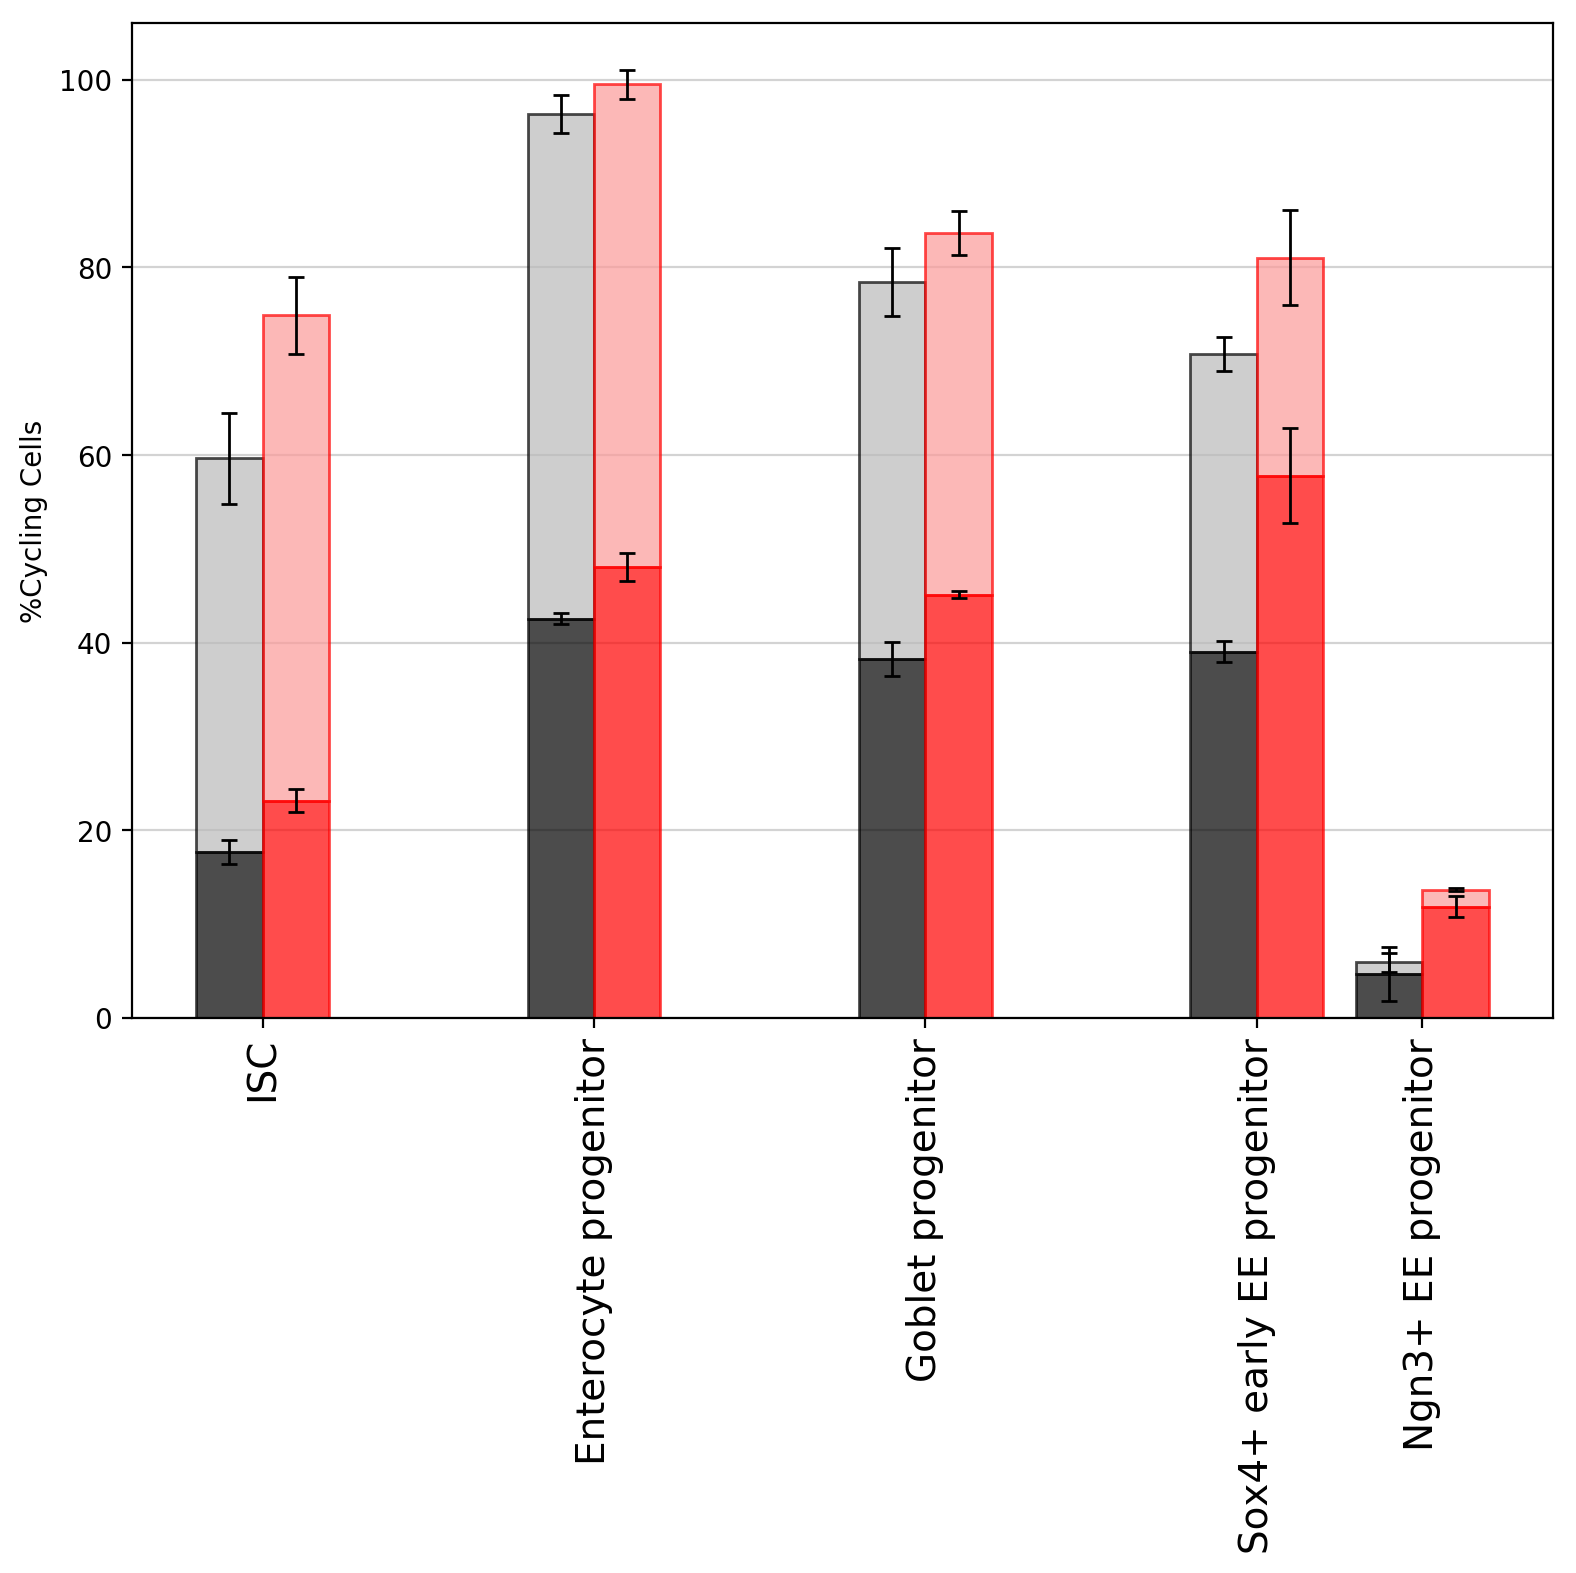

In [33]:
rcParams['figure.figsize'] = (8, 8)
df_all = bar_frequency_proliferation_phase_stack(adata_all,
                                                 group='groups_named_prog_eec',
                                                 celltype1='CD', celltype2='HFD',
                                                 group_names=['ISC', 'Enterocyte progenitor', 'Goblet progenitor', 'Sox4+ early EE progenitor', 'Ngn3+ EE progenitor'], 
                                                 index=np.array([1,3,5,7,8]), # x-axis position
                                                 bar_width=0.4,
                                                 saveimage="./figures/S8_bar_freq_proliferation_rest.pdf", dpisave=300,
                                                 savefreq="./S8_freq_proliferation.xlsx")
pl.rcParams.update(pl.rcParamsDefault)

In [34]:
df_all

,CD S (mean),CD S (std),CD G2M (mean),CD G2M (std),HFD S (mean),HFD S (std),HFD G2M (mean),HFD G2M (std)
groups_named_prog_eec,,,,,,,,
ISC,41.996798,4.875461,17.644350,1.254854,51.744376,4.111719,23.143342,1.206614
Enterocyte progenitor,53.816280,2.023389,42.531740,0.606357,51.416659,1.506388,48.084193,1.489190
Goblet progenitor,40.251888,3.620259,38.206886,1.802692,38.517684,2.336992,45.117243,0.402754
Sox4+ early EE progenitor,31.721188,1.816094,39.019235,1.136652,23.238468,5.081520,57.796639,5.051084
Ngn3+ EE progenitor,1.282051,1.046790,4.621348,2.876608,1.781212,0.161664,11.851200,1.153763


13366
14321


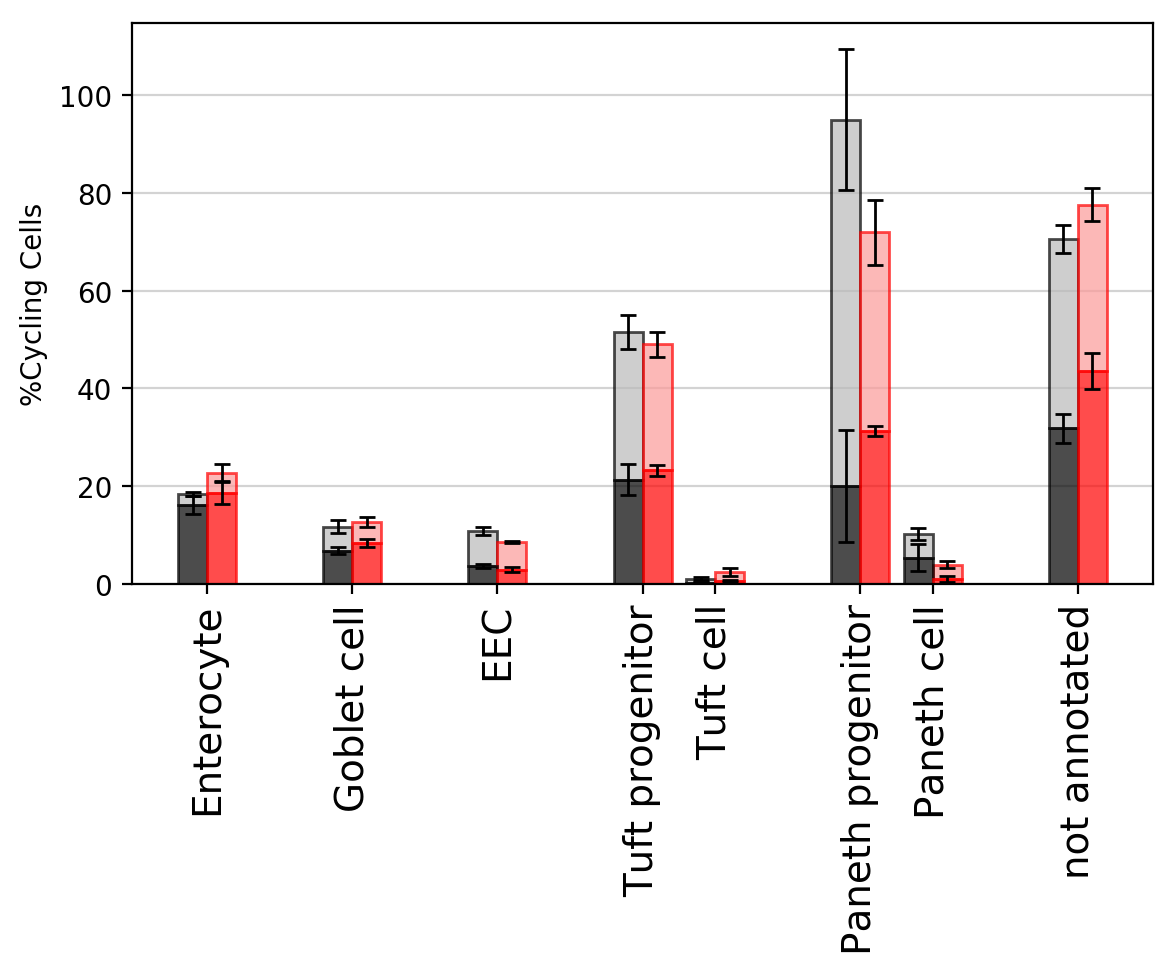

In [35]:
rcParams['figure.figsize'] = (6, 5)
df_all = bar_frequency_proliferation_phase_stack(adata_all,
                                                 group='groups_named_prog_eec', 
                                                 celltype1='CD', celltype2='HFD',
                                                 group_names=['Enterocyte','Goblet cell', 'EEC', 'Tuft progenitor', 'Tuft cell', 'Paneth progenitor', 'Paneth cell', 'not annotated'],
                                                 index=np.array([1,3,5,7,8,10,11,13]), # x-axis position
                                                 bar_width=0.4,
                                                 saveimage="./figures/4_bar_freq_proliferation_rest.pdf", dpisave=300,
                                                 savefreq="./4_freq_proliferation.xlsx")
pl.rcParams.update(pl.rcParamsDefault)

In [36]:
df_all

,CD S (mean),CD S (std),CD G2M (mean),CD G2M (std),HFD S (mean),HFD S (std),HFD G2M (mean),HFD G2M (std)
groups_named_prog_eec,,,,,,,,
Enterocyte,2.127560,0.406043,16.135038,1.853744,4.187438,1.760087,18.551074,2.340055
Goblet cell,4.874484,1.324061,6.740511,0.647928,4.368049,0.997632,8.311184,0.901527
EEC,7.166594,0.871556,3.635822,0.428970,5.636039,0.235733,2.820595,0.501617
Tuft progenitor,30.215461,3.446394,21.275985,3.149697,25.840152,2.573279,23.158971,1.169049
Tuft cell,0.761124,0.311578,0.182149,0.148724,1.845100,0.826533,0.563049,0.261963
Paneth progenitor,75.000000,14.433757,20.000000,11.547005,40.733666,6.699038,31.209856,1.077221
Paneth cell,4.816375,1.309955,5.336759,2.696948,2.933212,0.713342,0.967391,0.625244
not annotated,38.739753,2.826301,31.799883,2.931506,34.006985,3.408351,43.565849,3.620605


### Cell densities in cell score space

In [37]:
def cal_density_obs(adata, xobs, yobs, obsname):

    from scipy.stats import gaussian_kde

    x = adata.obs[xobs]
    y = adata.obs[yobs]

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    adata.obs[obsname+'_density'] = z

    return(adata)

In [38]:
def plot_density_obs(adata, adata_full, xobs, yobs, obsname, cmap='Greys', greysize=5, colorsize=10, colbar=False, vmax=3, savefile=None, dpisave=300):
   
    from scipy.stats import gaussian_kde

    z = adata.obs[obsname+'_density']
    x = adata.obs[xobs]
    y = adata.obs[yobs]
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = pl.subplots()
    ax.scatter(adata_full.obs[xobs], adata_full.obs[yobs], c='lightgrey', edgecolor='', s=greysize, rasterized=True)
        
    if vmax==0:
        vmax=max(z)
    
    ax.scatter(x, y, c=z, s=colorsize, edgecolor='', cmap=cmap, vmax=vmax, rasterized=True)
    if colbar:
        fig.colorbar(i,ax=ax)
    pl.grid(b=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel(xobs)
    ax.set_ylabel(yobs)
    
    
    ax.plot([0,ax.get_xlim()[1]], [0,ax.get_ylim()[1]], ls=":", c="red",)
    
    ### position of 0 in terms of axes fraction
    xrange=ax.get_xlim()
    xp=abs(0-xrange[0])
    xall=xrange[1]-xrange[0]
    x=xp/xall
    
    ax.axhline(y=0, xmin=0, xmax=x, color='red', linestyle=':')
    
    ### position of 0 in terms of axes fraction
    yrange=ax.get_ylim()
    yp=abs(0-yrange[0])
    yall=yrange[1]-yrange[0]
    y=yp/yall
    
    ax.axvline(x=0, ymin=0, ymax=y, color='red', linestyle=':')

    pl.xlabel('G2M Score')
    pl.ylabel('S Score')
    pl.xticks([])
    pl.yticks([])
    
    if savefile is not None:
        pl.savefig(savefile, dpi=dpisave, format='pdf')
    pl.show()
    return()

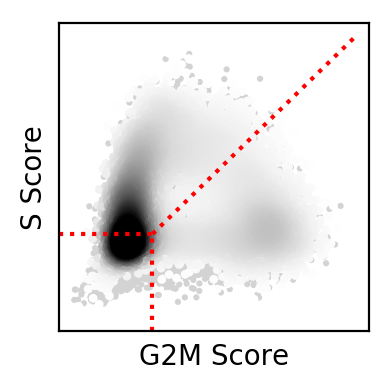

()

In [39]:
rcParams['figure.figsize'] = (2, 2)
adata_sub = adata_all[adata_all.obs['diet'].isin(['CD']), :].copy()
adata_sub = adata_sub[adata_sub.obs['groups_named_prog4'].isin(['ISC','Enterocyte progenitor','Goblet progenitor','Sox4+ early EE progenitor','Ngn3+ EE progenitor'])].copy()

adata_sub= cal_density_obs(adata_sub, 'G2M_score', 'S_score', 'cellcycle')

plot_density_obs(adata_sub, adata_all, 'G2M_score','S_score', obsname='cellcycle', savefile='./figures/4_score_density_CD.pdf')

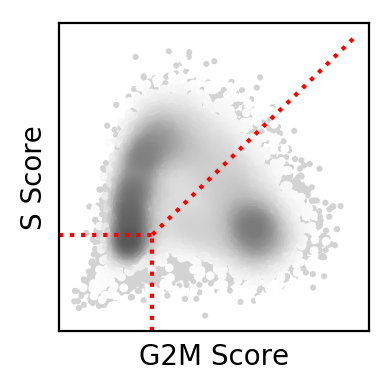

()

In [40]:
rcParams['figure.figsize'] = (2, 2)
adata_sub = adata_all[adata_all.obs['diet'].isin(['HFD']), :].copy()
adata_sub = adata_sub[adata_sub.obs['groups_named_prog4'].isin(['ISC','Enterocyte progenitor','Goblet progenitor','Sox4+ early EE progenitor','Ngn3+ EE progenitor'])].copy()
adata_sub= cal_density_obs(adata_sub, 'G2M_score', 'S_score', 'cellcycle')
plot_density_obs(adata_sub, adata_all, 'G2M_score','S_score', obsname='cellcycle', savefile='./figures/4_score_density_HFD.pdf')

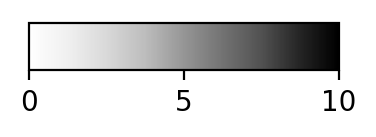

In [41]:
# plot colorbar
rcParams['figure.figsize'] = (2, 0.3)
fig, ax = pl.subplots()
cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
pl.show()

### Differential cell cycle gene expression in cycling cells of HFD mice

#### Compute correlation of gene expression to S and G2M score

In [42]:
df_corr = pd.DataFrame(index=adata_all_hvg.var_names, columns=['pearson_cor_S', 'pearson_cor_G2M'])

In [43]:
%%time
# correlation to S score
for i, gene in enumerate(adata_all_hvg.var_names):  
    cor = np.corrcoef(adata_all_hvg.obs['S_score'], adata_all_hvg[:,gene].X)
    df_corr.loc[gene, 'pearson_cor_S'] = cor[1][0]

CPU times: user 56.7 s, sys: 492 ms, total: 57.2 s
Wall time: 57.9 s


In [44]:
%%time
# correlation to G2M score
for i,gene in enumerate(adata_all_hvg.var_names):   
    cor = np.corrcoef(adata_all_hvg.obs['G2M_score'], adata_all_hvg[:,gene].X)
    df_corr.loc[gene, 'pearson_cor_G2M'] = cor[1][0]

CPU times: user 53.8 s, sys: 306 ms, total: 54.2 s
Wall time: 54.3 s


#### Significantly regulated cell cycle genes in HFD

In [45]:
cell_cycle_genes = [x.strip() for x in open('./cell_cycle_genes.txt')]

In [46]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_all.var_names]

In [47]:
# genes with high cell cycle score correlation
genes_cor_s = list(df_corr.loc[df_corr['pearson_cor_S']>0.7].index)
genes_cor_g2m = list(df_corr.loc[df_corr['pearson_cor_G2M']>0.7].index)

In [48]:
# concatenate
gene_names = list(set(genes_cor_s).union(genes_cor_g2m, cell_cycle_genes))

identify cell cycle genes with significant change in cycling cells of HFD mice in any cell type

In [49]:
xls = pd.ExcelFile('./differential_expression/Supplementary Table 5.xlsx')

sig_genes = []

cats = ['ISC', 'Enterocyte progenitor', 'Goblet progenitor', 'Sox4+ early EE progenitor', 'Ngn3+ EE progenitor']

for i, group in enumerate(cats):
    
    try:
        
        # significant upregulation
        data_up = pd.read_excel(xls, group+'_up',index_col=0)
        ix_fc = data_up['logFC']>0.1
        data_up = data_up[ix_fc]

        ix_p = data_up['adj.P.Val']<0.01
        data_up = data_up[ix_p]
        
        ix = np.isin(data_up.index, gene_names)
        sig_genes.extend(data_up.index[ix])

        # significant downregulation
        data_down = pd.read_excel(xls, group+'_down',index_col=0)
        ix_fc = data_down['logFC']<-0.1
        data_down = data_down[ix_fc]

        ix_p = data_down['adj.P.Val']<0.01
        data_down = data_down[ix_p]
                
        ix = np.isin(data_down.index, gene_names)
        sig_genes.extend(data_down.index[ix])
                       
    except XLRDError:
        pass
       
sig_genes = np.unique(sig_genes)

#### Heatmap with foldchanges

In [50]:
### prepare data

# subset to genes
adata_marker_scale = adata_all[:, sig_genes].copy() 

# scale data for plotting
adata_marker_scale = sc.pp.scale(adata_marker_scale, max_value=3, copy=True, zero_center=False) 

# subset to Cycling cells
adata_marker_scale = adata_marker_scale[adata_marker_scale.obs['proliferation'].isin(['Cycling'])].copy()

In [51]:
### load differential expression results 
xls = pd.ExcelFile('./differential_expression/Supplementary Table 5.xlsx')

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


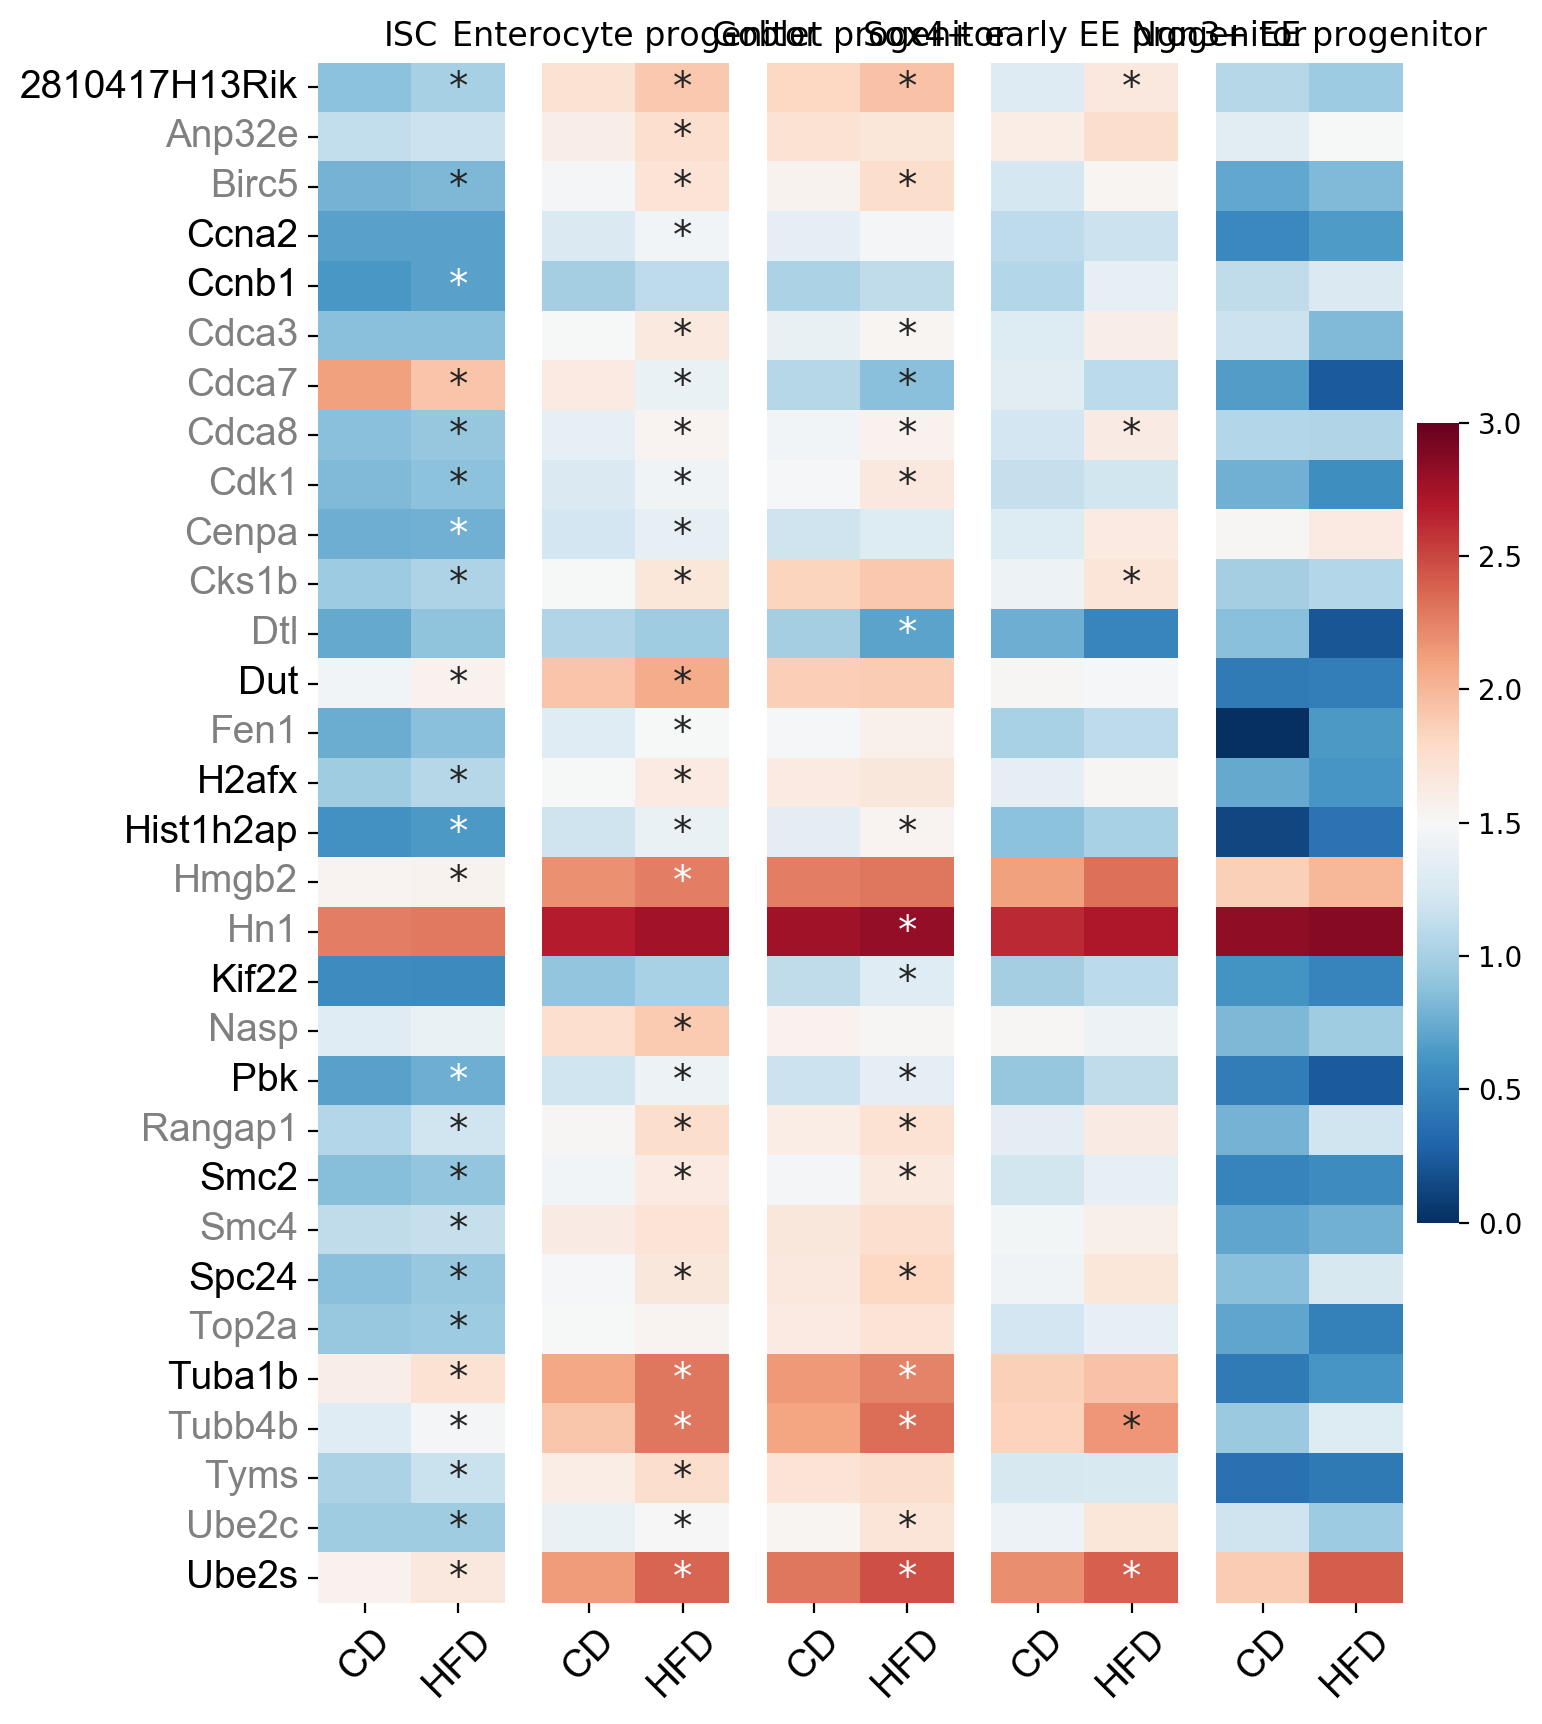

In [55]:
### plot heatmap
cats=['ISC', 'Enterocyte progenitor', 'Goblet progenitor', 'Sox4+ early EE progenitor','Ngn3+ EE progenitor']

#rcParams['figure.figsize'] = (7, 10)
fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.2}, figsize=(7, 10))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i,group in enumerate(cats):
    
    # subset to cell type
    adata_sub = adata_marker_scale[adata_marker_scale.obs['groups_named_prog_eec'].isin([group])].copy()
    
    # get mean expression per condition
    df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
    df['diet'] = adata_sub.obs['diet'].values
    df_mean = df.groupby(['diet']).mean()[sig_genes]
    
    try:   
        # significant upregulation
        data_up = pd.read_excel(xls, sheet_name=group+'_up',index_col=0)
        ix_fc = data_up['logFC']>0.1
        data_up = data_up[ix_fc]

        ix_p = data_up['adj.P.Val']<0.01
        data_up = data_up[ix_p]
        
        genes_up = np.isin(df_mean.columns, data_up.index)
                
        # significant downregulation
        data_down = pd.read_excel(xls, sheet_name=group+'_down',index_col=0)
        ix_fc = data_down['logFC']<-0.1
        data_down = data_down[ix_fc]

        ix_p = data_down['adj.P.Val']<0.01
        data_down = data_down[ix_p]
                
        genes_down = np.isin(df_mean.columns, data_down.index)
        
        annots  = np.array([['','*'] if any(tup) else ['',''] for tup in zip(genes_up, genes_down)])
        
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax,
                    annot=annots, fmt='', vmin=0, vmax=3, annot_kws={'fontsize':14, 'horizontalalignment':'center'})
        
        del annots
        
    except XLRDError:
        pass
    
    if 'annots' not in locals():
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax, vmin=0, vmax=3)
    
    axs[i].set_title(group)
    axs[i].set_ylabel('')
       
    if i==0:
        # set color of x-tick labels
        # grey if strongly correlating, black if from gene sets used for scoring
        col1 = np.array(['grey' if gene in cell_cycle_genes else 'black' for gene in df_mean.columns]) 
        axs[i].set_yticklabels(df_mean.columns, fontdict={'verticalalignment': 'center', 'rotation':0, 'fontsize':14, 'fontname':'Arial'})
      
        for color,tick in zip(col1,axs[i].yaxis.get_major_ticks()):
            tick.label1.set_color(color)

    axs[i].set_xlabel('')
    axs[i].set_xticklabels(['CD','HFD'], fontdict={'rotation':45,'fontsize':14,'fontname':'Arial'})
    del df
    
fig.tight_layout(rect=[0, 0, .9, 1])
pl.savefig('./figures/4_heatmap.pdf', dpi=600, format='pdf')
pl.show()
pl.rcParams.update(pl.rcParamsDefault)